In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, ode

# Animation packages
from matplotlib import animation
from IPython.display import HTML
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
class Args(object):
    __slots__ = ['B', 'J', 'K1', 'K2', 'La', 'Ra']
    
    def __init__(self):
        self.B = 1
        self.J = 1
        self.K1 = 1
        self.K2 = 1
        self.La = 1
        self.Ra = 1

In [3]:
def create_AQ(args: Args) -> np.ndarray:
    AQ = np.zeros(shape=(6, 6), dtype=np.float32)
    AQ[0, 3] = 2
    AQ[1, 1] = -2 * args.B / args.J
    AQ[1, 5] = 2 * args.K2 / args.J
    AQ[2, 2] = -2 * args.Ra / args.La
    AQ[2, 5] = -2 * args.K1 / args.La
    AQ[3, 1] = 1
    AQ[3, 3] = -args.B / args.J
    AQ[3, 4] = args.K2 / args.J
    AQ[4, 3] = -args.K1 / args.La
    AQ[4, 4] = -args.Ra / args.La
    AQ[4, 5] = 1
    AQ[5, 1] = -args.K1 / args.La
    AQ[5, 2] = args.K2 / args.J
    AQ[5, 5] = -args.B / args.J - args.Ra / args.La
    return AQ

In [4]:
class diff(object):
    __slots__ = ['AQ']
    
    def __init__(self, AQ):
        self.AQ = AQ
    
    def __call__(self, y, t):
        return self.AQ.dot(y)

In [5]:
class mistery_eq(object):
    __slots__ = ['A', 'f']
    
    def __init__(self, A, f):
        self.A = A
        self.f = f
    
    def __call__(self, x, t):
        return self.A.dot(x) + f(t)

In [6]:
class func_f(object):
    __slots__ = ['e']
    
    def __init__(self, e):
        self.e = e
    
    def __call__(self, t):
        f = np.zeros(shape=(3,), dtype=np.float32)
        f[2] = self.e(t)
        return f

In [7]:
def create_A(args: Args) -> np.ndarray:
    A = np.zeros(shape=(3, 3), dtype=np.float32)
    A[0, 1] = 1
    A[1, 1] = -args.B / args.J
    A[1, 2] = args.K2 / args.J
    A[2, 1] = -args.K1 / args.La
    A[2, 2] = -args.Ra / args.La
    return A

In [8]:
def calc_y0_by_Q0(Q0: np.ndarray) -> np.ndarray:
    y0 = np.empty(shape=(6,), dtype=np.float32)
    y0[0] = Q0[0, 0]
    y0[1] = Q0[1, 1]
    y0[2] = Q0[2, 2]
    y0[3] = Q0[0, 1]
    y0[4] = Q0[0, 2]
    y0[5] = Q0[1, 2]
    return y0

In [9]:
def calc_Q_by_vec(q_vec: np.ndarray) -> np.ndarray:
    Q = np.empty(shape=(3, 3), dtype=np.float32)
    Q[0, 0] = q_vec[0]
    Q[1, 1] = q_vec[1]
    Q[2, 2] = q_vec[2]
    Q[0, 1] = q_vec[3]
    Q[1, 0] = q_vec[3]
    Q[0, 2] = q_vec[4]
    Q[2, 0] = q_vec[4]
    Q[1, 2] = q_vec[5]
    Q[2, 1] = q_vec[5]
    return Q

In [10]:
t0 = 0
T = 1
time_steps = 100

args = Args()
Q0 = np.array([[1, 0, 0],
               [0, 2, 0],
               [0, 0, 1]])
x0 = np.array([0, 0, 0])
e = np.sin

In [11]:
times = np.linspace(t0, T, time_steps)
AQ = create_AQ(args)
y0 = calc_y0_by_Q0(Q0)
func = diff(AQ)

A = create_A(args)
f = func_f(e)
right_part = mistery_eq(A, f)

In [12]:
q_discr = odeint(func, y0, times)
Q_list = list()
for q_vec in q_discr:
    Q = calc_Q_by_vec(q_vec)
    Q_list.append(Q)

p_discr = odeint(right_part, x0, times)

In [13]:
X_1, X_2 = -2.1, 2.1
Y_1, Y_2 = -2.1, 2.1
Z_1, Z_2 = -2.1, 2.1

_step = 0.02

X = np.arange(X_1, X_2, _step, dtype=np.float16)
Y = np.arange(Y_1, Y_2, _step, dtype=np.float16)
Z = np.arange(Z_1, Z_2, _step, dtype=np.float16)

grid = np.array(np.meshgrid(X, Y, Z))
grid_2d = np.array(np.meshgrid(X, Y))

In [14]:
# Q_curr = Q_list[0]
# p_curr = p_discr[0]

# Q_inv = None
# try:
#     Q_inv = np.linalg.inv(Q_curr)
# except BaseException as err:
#     Q_inv = np.linalg.pinv(Q_curr)

# d_grid = grid - p_curr[:, np.newaxis, np.newaxis, np.newaxis]
# vals = np.sum(Q_inv.dot(np.transpose(d_grid, axes=(1, 2, 0, 3))) * d_grid, axis=0)
# vals_2d = np.bitwise_or.reduce(vals <= 1, axis=-1)
# img = np.zeros(shape=(len(Y), len(X)), dtype=np.uint8)
# img[vals_2d] = 255
# print(np.count_nonzero(img))
# plt.imshow(img)

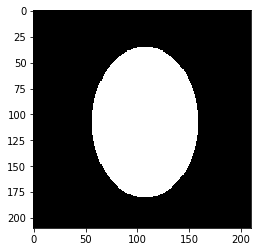

In [15]:
fig = plt.figure()
im = plt.imshow(np.zeros(shape=(len(Y), len(X)), dtype=np.uint8), animated=True)

def animate(i):
    Q_inv = None
    try:
        Q_inv = np.linalg.inv(Q_list[i])
    except BaseException as err:
        Q_inv = np.linalg.pinv(Q_list[i])
    p_curr = p_discr[i]
    
    d_grid = grid - p_curr[:, np.newaxis, np.newaxis, np.newaxis]
    vals = np.sum(Q_inv.dot(np.transpose(d_grid, axes=(1, 2, 0, 3))) * d_grid, axis=0)
    vals_2d = np.bitwise_or.reduce(vals <= 1, axis=-1)
    img = np.zeros(shape=(len(Y), len(X)), dtype=np.uint8)
    img[vals_2d] = 255

    im.set_array(np.transpose(np.array([img]*3), axes=(1, 2, 0)))
    return im,

anim = animation.FuncAnimation(fig, animate, frames=len(Q_list), interval=50)
vidos = HTML(anim.to_html5_video())

In [16]:
vidos